<a href="https://colab.research.google.com/github/amanjain487/tsai-eva6/blob/main/Assignments/S7/S7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial Accuracy : 54

After normalizing with mean and std : 61

With Image Augmentation : 

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary
import torchvision.transforms as transforms

!pip install git+https://github.com/albumentations-team/albumentations.git
import albumentations as A

import sys
import os

py_file_location = '/content/drive/MyDrive/Colab Notebooks/S7/'
sys.path.append(os.path.abspath(py_file_location))
%matplotlib inline
import matplotlib.pyplot as plt
import model
from model import Net 

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-2fdypb_b
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-2fdypb_b
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98151 sha256=596f47708dff929c35f9a34a634373fe5aaa64d303b3ae3fc68b1b905bbd8441
  Stored in directory: /tmp/pip-ephem-wheel-cache-kyrpqxam/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations


In [ ]:


!pip install torchsummary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [ ]:

sample_transform = transforms.Compose([transforms.ToTensor()])

sample_trainset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/Colab Notebooks/cifar10_raw_data/', train=True,
                                        download=True, transform=sample_transform)
sample_trainloader = torch.utils.data.DataLoader(sample_trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

mean = 0.
std = 0.
for images, _ in sample_trainloader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(sample_trainloader.dataset)
std /= len(sample_trainloader.dataset)


Files already downloaded and verified


In [ ]:
print(mean,std)

tensor([0.4914, 0.4822, 0.4465]) tensor([0.2023, 0.1994, 0.2010])


In [ ]:
from torch.utils.data import DataLoader, Dataset
import numpy

kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}


test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=mean, std=std)])
transform = transforms.Compose([transforms.Normalize(mean=mean, std=std)])
train_transform = A.Compose(
    [
     A.HorizontalFlip(p=0.5),
     A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
     A.CoarseDropout(p=0.5, max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=(mean), mask_fill_value = None),
     A.ToGray(p=0.5)
    ]
)
class CIFAR_10_Dataset(torch.utils.data.Dataset):
  def __init__(self,  dataset, transformer=None):
        self.dataset = dataset
        self.transforms = transformer
  def __len__(self):
        return len(self.dataset)
  def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img, target = self.dataset[idx]
        img = img.cpu().detach().numpy()
        img = np.asarray(img).reshape((32,32,3))
        if self.transforms is not None:
            image = self.transforms(image=img)
        img = torch.from_numpy(img.reshape(3,32,32))
        return img, target



train_dataset = CIFAR_10_Dataset(datasets.CIFAR10('/content/drive/MyDrive/Colab Notebooks/cifar10_raw_data/', train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean, std=std)
                                  ])), train_transform)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, **kwargs)

testset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/Colab Notebooks/cifar10_raw_data/', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=True, **kwargs)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import numpy as np
criterion = nn.CrossEntropyLoss()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    processed = 0
    for i, x in enumerate(train_loader, 0):
        data, target = x
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        training_losses.append(loss)
        loss.backward()
        optimizer.step()
        _, predictions = torch.max(output.data, 1)
        correct += (predictions == target).sum().item()
        processed += len(data)
        training_accuracy.append(100*correct/processed)
        #pbar.set_description(desc= f'Train set: Accuracy={100*correct/processed:0.1f}')
        training_accuracy.append(100*correct/processed)
    print('Train set: Accuracy={:0.1f}'.format(100*correct/processed))



def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target)
            _, predictions = torch.max(output.data, 1)
            correct += (predictions == target).sum().item()

    test_loss /= len(test_loader.dataset)
    testing_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    testing_accuracy.append(100. * correct / len(test_loader.dataset))

In [ ]:
def eval(model, test_loader):
  model.eval()
  test_loss = 0.0
  correct = 0
  im_pred = {'Wrong': []}
  i = 1
  plt_dt = dict()
  with torch.no_grad():
      for data, target in test_loader:
          if (len(im_pred['Wrong'])<20):
              data, target = data.to(device), target.to(device)
              output = model(data)
              test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
              pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
              correct += pred.eq(target.view_as(pred)).sum().item()
              i+=1
              plt_dt['Input'], plt_dt['target'], plt_dt['pred'] = data.to('cpu'), target.to('cpu'), pred.to('cpu').view(-1,)

              for id in range(len(data)):
                  if plt_dt['target'][id] != plt_dt['pred'][id]:
                      im_pred['Wrong'] = im_pred['Wrong']+ [{'Image':data[id],'pred':pred[id],'actual' : target[id]}]
  
  plt.figure(figsize=(14,14)) 
  for i in range(20):
      plt.subplot(4,5,i+1)  
      pixels = np.array(im_pred['Wrong'][i]['Image'].cpu() , dtype='uint8')

      # Reshape the array into 32 x 32 array (3-dimensional array)
      pixels = pixels.reshape((3, 32, 32))

      # Plot
      plt.title('Actual Value is {label}\n Predicted Value is {pred}'.format(label=im_pred['Wrong'][i]['actual'].cpu(), pred =im_pred['Wrong'][i]['pred'].cpu()[0]), color='r')
      plt.imshow(pixels, cmap='gray')

  plt.show()

In [ ]:
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
           Dropout-3           [-1, 16, 32, 32]               0
              ReLU-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 30, 32, 32]           4,320
       BatchNorm2d-6           [-1, 30, 32, 32]              60
           Dropout-7           [-1, 30, 32, 32]               0
              ReLU-8           [-1, 30, 32, 32]               0
            Conv2d-9           [-1, 50, 32, 32]          13,500
      BatchNorm2d-10           [-1, 50, 32, 32]             100
          Dropout-11           [-1, 50, 32, 32]               0
             ReLU-12           [-1, 50, 32, 32]               0
           Conv2d-13           [-1, 50, 16, 16]          10,000
      BatchNorm2d-14           [-1, 50,

In [ ]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR

training_losses = []
testing_losses = []
training_accuracy = []
testing_accuracy = []


model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size = 25, gamma=0.1)

for epoch in range(1, 41):
    print("EPOCH:", epoch, "LR = ", scheduler.get_lr())
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)
    scheduler.step()


EPOCH: 1 LR =  [0.01]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train set: Accuracy=43.3
Test set: Average loss: 0.0107, Accuracy: 5311/10000 (53.1%)

EPOCH: 2 LR =  [0.01]
Train set: Accuracy=59.9
Test set: Average loss: 0.0094, Accuracy: 5874/10000 (58.7%)

EPOCH: 3 LR =  [0.01]
Train set: Accuracy=67.5
Test set: Average loss: 0.0079, Accuracy: 6511/10000 (65.1%)

EPOCH: 4 LR =  [0.01]
Train set: Accuracy=72.0
Test set: Average loss: 0.0068, Accuracy: 7099/10000 (71.0%)

EPOCH: 5 LR =  [0.01]
Train set: Accuracy=75.0
Test set: Average loss: 0.0069, Accuracy: 7086/10000 (70.9%)

EPOCH: 6 LR =  [0.01]
Train set: Accuracy=77.4
Test set: Average loss: 0.0059, Accuracy: 7422/10000 (74.2%)

EPOCH: 7 LR =  [0.01]
Train set: Accuracy=79.4
Test set: Average loss: 0.0072, Accuracy: 7013/10000 (70.1%)

EPOCH: 8 LR =  [0.01]
Train set: Accuracy=80.6
Test set: Average loss: 0.0054, Accuracy: 7638/10000 (76.4%)

EPOCH: 9 LR =  [0.01]
Train set: Accuracy=81.7
Test set: Average loss: 0.0053, Accuracy: 7759/10000 (77.6%)

EPOCH: 10 LR =  [0.01]
Train set: Accurac

## Plotting Training Loss, Test Loss, Training Accuracy, Test Accuracy¶


Text(0.5, 1.0, 'Test Accuracy')

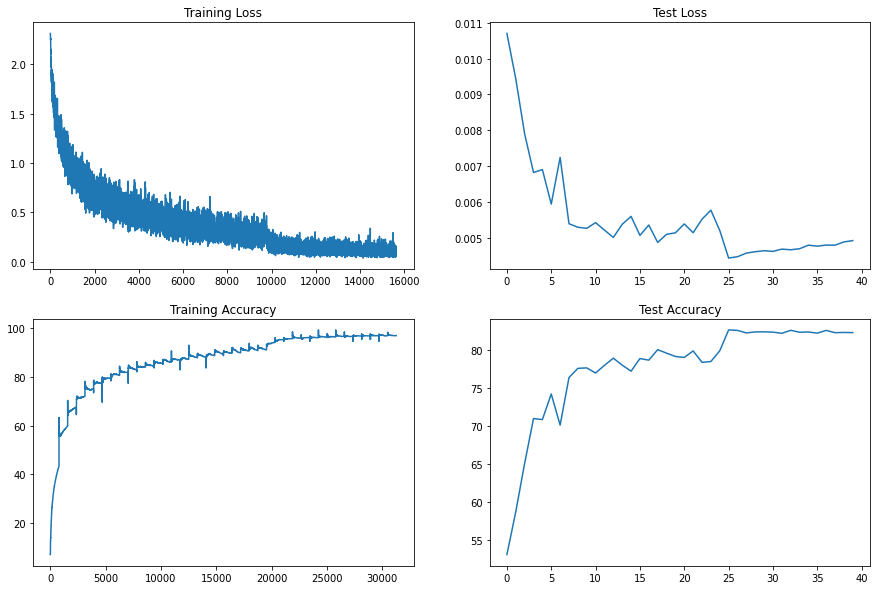

In [ ]:

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(training_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(training_accuracy)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(testing_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(testing_accuracy)
axs[1, 1].set_title("Test Accuracy")

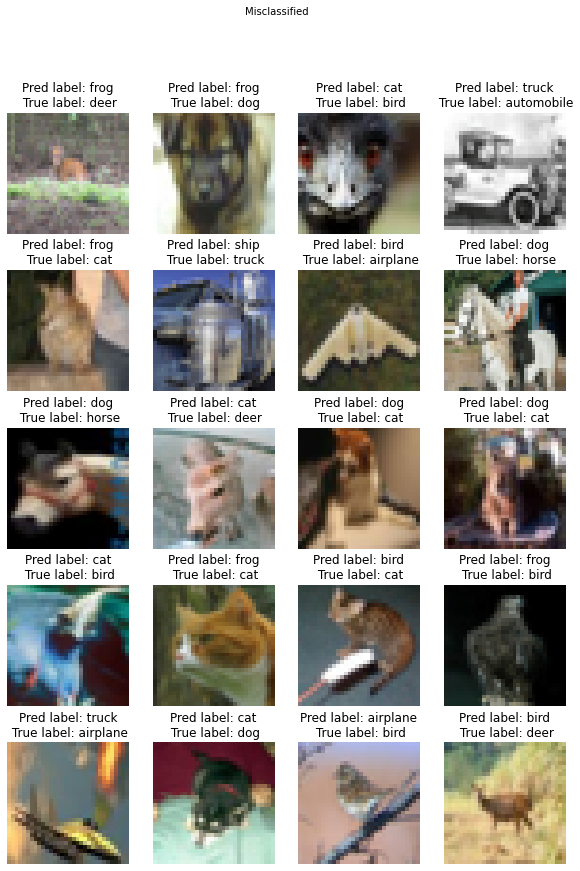

In [ ]:
def plot_misclassified(model, test_loader, n=20, title='Misclassified'):
  count = 0
  k = 30
  mis = []
  classes = testset.classes
  
  while count<=n:
    img, label = test_loader.dataset[k]
    img, label = img.unsqueeze(0).cpu(), label
    pred = model(img.cuda()) # Prediction
    pred = pred.cpu()
    # pred = model(img.unsqueeze(0).to(device)) # Prediction
    pred = pred.argmax().item()

    k += 1
    if pred!=label:
      denormalize = transforms.Normalize((-1 * mean / std), (1.0 / std))
      img = denormalize(img)
      mis.append((img, label, pred))
      count += 1
  
  rows, cols = int(count/4),4
  figure = plt.figure(figsize=(10,14))

  for i in range(1, cols * rows + 1):
    img, label, pred = mis[i-1]

    figure.add_subplot(rows, cols, i) # adding sub plot
    plt.suptitle(title, fontsize=10)
    plt.title(f"Pred label: {classes[pred]}\n True label: {classes[label]}") # title of plot
    plt.axis("off") # hiding the axis
    img = img.squeeze().numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img, cmap="gray") # showing the plot

  plt.show()

plot_misclassified(model, testloader)